In [2]:
import numpy as np
import pickle
import pandas as pd
import sys
import matplotlib.pyplot as plt

my_path = sys.path[0]
while (my_path[-1] != "/") and (my_path[-1] != "\\"):
    my_path = my_path[:-1]

sys.path.insert(1, my_path + "Model")

from model_nile import ModelNile

**Setting things:**

In [4]:
nile_model = ModelNile()
yearly_demand_growth_rate = 0.02
sim_horizon = 20
np.random.seed(123)

# Demand Data:

Monthly demand values come from [Wheeler et al. (2016)](https://www.tandfonline.com/doi/suppl/10.1080/02508060.2016.1177698/suppl_file/rwin_a_1177698_sm6059.pdf) supplementary data. I converted it to **m3/sec** from BCM/month. To generate sufficient monthly demand throughout the simulation horizon, a constant **yearly demand growth rate** will be assumed. A rough assumption of **2%** demand growth is the baseline given this source on [NBI Atlas](https://atlas.nilebasin.org/treatise/population-growth-rates-in-nile-basin-countries/). Though, I haven't grown the demand between years 2016-2022! (despite this study being published in 2016)

In [3]:
for district in nile_model.irr_districts.values():
        one_year = np.loadtxt(f"IrrDemand{district.name}.txt")
        demand_vector = np.empty(0)
        loop_counter = sim_horizon
        while loop_counter > 0:
            demand_vector = np.append(demand_vector, one_year)
            one_year *= (1+yearly_demand_growth_rate)
            loop_counter -= 1
        district.demand = demand_vector

Let's show the dynamics of total yearly demand in the basin:

In [4]:
day_count = nile_model.nu_of_days_per_month

total_yearly_demand = np.empty(0)

for i in range(sim_horizon):
    total_this_year = 0
    for district in nile_model.irr_districts.values():
        for j in range(12):
            total_this_year += district.demand[i*12+j]*day_count[j]*24*3600*1e-9
    total_yearly_demand = np.append(total_yearly_demand, total_this_year)

In [5]:
total_yearly_demand

array([67.866     , 69.22332   , 70.6077864 , 72.01994212, 73.46034097,
       74.92954779, 76.42813874, 77.95670152, 79.51583555, 81.10615226,
       82.7282753 , 84.38284081, 86.07049763, 87.79190758, 89.54774573,
       91.33870064, 93.16547466, 95.02878415, 96.92935983, 98.86794703])

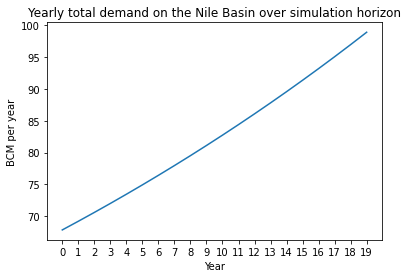

In [6]:
plt.xticks(range(20))
plt.plot(range(20),total_yearly_demand)
plt.rcParams["figure.figsize"] = (40,15)
plt.ylabel("BCM per year")
plt.xlabel("Year")
plt.title("Yearly total demand on the Nile Basin over simulation horizon")
plt.show()
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]


# Inflow Data:

Here I distinguish two types of inflow data: 
- Major tributaries (Blue Nile, White Nile, Atbara River)
- Minor catchments

For the former, I have some gauging station measurements. For the latter, I have the detailed conceptualisation laid out in [Wheeler et al. (2018)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2017WR022149). The authors of this study generated future streamflows considering three alternative formulation of the statistical generating process (100 realisations of each stochastic distribution gives 300 possible sets). Given the focal point of my research not being particularly a realistic prediction of future inflow occurences, I decided to use this dataset as alternative realisations. However, there is no immediately available data for the main tributaries --in fact, the more important category of inflows--. My strategy is to generate alternative realisations as simply as possible. Following shows how it has been done for each of the tributaries:

## White Nile:

Based on the conceptual model schematic presented in [Wheeler et al. (2018)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2017WR022149), I decided to consider the contribution of the incoming flow from the White Nile as the measurement made in the Mogren gauging station. I could find limited amount of measurement data on [UNH/GRDC Composite Runoff Fields](https://www.compositerunoff.sr.unh.edu/html/Polygons/P1673100.html) in the form of **mean**, **min**, **max** inflow per month. My initial strategy will be to assume the distribution of the inflow at each month is triangular distribution with min=min, mod=mean and max=max. With this simplistic assumption (one major limitation: not considering any autocorrelation among data points which is essential in hydrology), I will generate 20*12 = 240 data points.

In [7]:
mogren_dist = pd.read_csv("mogren_distribution.csv")
mogren = np.empty(0)
loop_counter = sim_horizon
while loop_counter > 0:
    m = list()
    for i in range(12):
        m.append(np.random.triangular(mogren_dist.loc[i,"MinQ"], mogren_dist.loc[i,"MeanQ"], mogren_dist.loc[i,"MaxQ"]))
    mogren = np.append(mogren, m)
    
    loop_counter -= 1

I add four minor inflows to the Mogren measurements (as these inflows join the system just after the White Nile joins the Main Nile, but before the next demand district). For that, let's load one of the baseline inflow scenarios that Wheeler et al. (2018) generated:

In [5]:
wh_data = pickle.load( open( "Baseline_wheeler.p", "rb" ) )
set_number = np.random.randint(1, 101)
numbered_catchments = wh_data[set_number]
# This data is generated for 2018 January and on. Therefore, I'll drop first four years:
numbered_catchments = numbered_catchments.iloc[49:(49+sim_horizon*12)]

In [7]:
type(wh_data)

list

In [12]:
pd.concat(wh_data, ignore_index=True).to_csv("Baseline_wheeler.csv", index=False)

In [14]:
wheeler_again = pd.read_csv("Baseline_wheeler.csv")

In [15]:
wheeler_list = [wheeler_again[i:i+600] for i in range(100)]

In [20]:
wh_data

[     325.Inflow  474.Inflow   1361.Inflow  3.Inflow  329.Inflow  1334.Inflow  \
 0        0.0000    0.537910  5.585300e-11   55.5230     0.85864     0.495540   
 1        0.0000    0.360180  5.585300e-11   37.1780     0.57494     0.331810   
 2        0.0000    0.158950  5.585300e-11   16.4070     0.25373     0.146430   
 3        0.0000    0.091023  8.061500e-02    9.3953     0.14529     0.083853   
 4        3.3042    0.108420  3.191000e+00   11.1910     0.17306     0.099880   
 ..          ...         ...           ...       ...         ...          ...   
 595     63.2230    6.897700  5.179500e+01  711.9800    11.01000     6.354400   
 596     42.1250    7.450300  3.468100e+01  769.0100    11.89200     6.863400   
 597      8.1215    4.229500  7.098600e+00  436.5700     6.75140     3.896400   
 598      0.0000    1.364500  6.773900e-02  140.8400     2.17800     1.257000   
 599      0.0000    0.796010  2.659200e-02   82.1640     1.27060     0.733320   
 
      1234.Inflow  450.Inf

In [25]:
wheeler_list[0] == wh_data[0]

,325.Inflow,474.Inflow,1361.Inflow,3.Inflow,329.Inflow,1334.Inflow,1234.Inflow,450.Inflow,201.Inflow,1338.Inflow,...,1319.Inflow,1364.Inflow,412.Inflow,343.Inflow,243.Inflow,524.Inflow,308.Inflow,1331.Inflow,204.Inflow,1352.Inflow
0,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
1,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
3,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
4,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
596,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
597,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
598,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


Overall, the inflow of my White Nile catchment is the sum of the inflow coming from the White Nile (Mogren station) plus Wheeler flow numbers 1364, 1338, 1317, 31. However, it turns out that authors could not find data for this inflows and since they are not comparable to the White Nile. We can just ignore:

In [9]:
numbered_catchments["1364.Inflow"] + numbered_catchments["1338.Inflow"] + numbered_catchments["1317.Inflow"] + numbered_catchments["31.Inflow"]

49     0.0
50     0.0
51     0.0
52     0.0
53     0.0
      ... 
284    0.0
285    0.0
286    0.0
287    0.0
288    0.0
Length: 240, dtype: float64

Similar to what we did with **demand**, let's calculate the total yearly contribution of the White Nile in billion cubic meters (BCM):

In [10]:
day_count = nile_model.nu_of_days_per_month

total_yearly_whitenile = np.empty(0)

for i in range(sim_horizon):
    total_this_year = 0
    for j in range(12):
        total_this_year += mogren[i*12+j]*day_count[j]*24*3600*1e-9
    total_yearly_whitenile = np.append(total_yearly_whitenile, total_this_year)

In [11]:
total_yearly_whitenile

array([29.44944943, 28.55093875, 27.71981741, 29.67446489, 29.06756505,
       28.80841526, 28.56068907, 30.2329631 , 27.82665219, 28.25579992,
       29.4884569 , 29.25920785, 28.78782949, 29.33390332, 28.60762887,
       28.27615466, 27.99932192, 29.0675467 , 28.94497437, 27.86695306])

## Atbara River:

Based on the conceptual model schematic presented in [Wheeler et al. (2018)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2017WR022149), I decided to consider the contribution of the incoming flow from the Atbara tributary as the measurement made in the **Atbara at Kilo 3** gauging station. I could find limited amount of measurement data on [Center for Sustainability and the Global Environment-
Nelson Institute for Environmental Studies](https://sage.nelson.wisc.edu/riverdata/station_table.php?qual=256&filenum=138) as incomplete monthly time-series data from year 1912 to 1982. My initial strategy will be to assume the distribution of the inflow at each month as Normal with mean=average of a month, std=standard deviation within a month. With this simplistic assumption (one major limitation: not considering any autocorrelation among data points which is essential in hydrology), I will generate 20*12 = 240 data points.

In [12]:
atbara_dist = pd.read_csv("atbara_distribution.csv")
atbara = np.empty(0)
loop_counter = sim_horizon
while loop_counter > 0:
    a = list()
    for i in range(12):
        a.append(max(0,np.random.normal(atbara_dist.loc[i,"mean"], atbara_dist.loc[i,"std"])))
    atbara = np.append(atbara, a)
    
    loop_counter -= 1

Let's calculate total yearly contribution again:

In [13]:
day_count = nile_model.nu_of_days_per_month

total_yearly_atbara = np.empty(0)

for i in range(sim_horizon):
    total_this_year = 0
    for j in range(12):
        total_this_year += atbara[i*12+j]*day_count[j]*24*3600*1e-9
    total_yearly_atbara = np.append(total_yearly_atbara, total_this_year)

In [14]:
total_yearly_atbara

array([ 9.22208845,  8.59468373, 10.54494517, 13.79561106, 11.42072213,
       10.90486621, 13.88102429,  6.43893181,  7.22619671, 11.14954709,
       12.89225516,  9.86842337,  7.45328365, 10.70582405, 11.12486231,
       16.22664228,  8.68975339, 13.67161882, 18.2662685 ,  9.90762756])

Quick visual observation over the numbers says that contribution coming from Atbara is around one-third of that coming from the White Nile. Atbara flows are more volatile.

## Blue Nile:

Since I draw my model boundary at the GERD, it has been challenging to find good inflow data. [Basheer et al. (2020)](https://www.cell.com/one-earth/fulltext/S2590-3322(20)30424-3?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS2590332220304243%3Fshowall%3Dtrue) supplementary information presents the average yearly flow of the Blue Nile as 50 BCM. To generate the flows in a basic fashion, I only need the indication of interannual variability. As an indication of that, I received monthly inflow measurements from the data set (how to refer). However, the yearly total of that data was ending up at a very low BCM value per year. Therefore, I scaled up those monthly values so as to equate the total yearly flow to 50 BCM (the figure authors mention). With that, I obtained a single (mean) value per each month. To generate some variability for the following 20 years, I assumed uniform distribution with +-30% lower and upper bounds:

In [15]:
bluenile_dist = pd.read_csv("blue_nile_series.csv")
bluenile = np.empty(0)
loop_counter = sim_horizon
while loop_counter > 0:
    b = list()
    for i in range(12):
        b.append(np.random.uniform(bluenile_dist.loc[i,"0"]*0.7, bluenile_dist.loc[i,"0"]*1.3))
    bluenile = np.append(bluenile, b)
    
    loop_counter -= 1

Calculate yearly total:

In [16]:
day_count = nile_model.nu_of_days_per_month

total_yearly_bluenile = np.empty(0)

for i in range(sim_horizon):
    total_this_year = 0
    for j in range(12):
        total_this_year += bluenile[i*12+j]*day_count[j]*24*3600*1e-9
    total_yearly_bluenile = np.append(total_yearly_bluenile, total_this_year)

In [17]:
total_yearly_bluenile

array([59.20771626, 59.83413874, 51.92849411, 51.82820441, 49.59873807,
       57.71837794, 49.27079649, 54.29190433, 46.13880032, 43.52076732,
       56.99455328, 51.30643731, 48.79592569, 52.35513222, 52.84610145,
       53.53347987, 46.40373901, 51.41301484, 51.06157891, 52.42182374])

## Minor catchments:

In [18]:
minors = dict()
minors["Dinder"] = np.array(numbered_catchments["340.Inflow"] + numbered_catchments["635.Inflow"] + \
    numbered_catchments["1308.Inflow"])
minors["Rahad"] = np.array(numbered_catchments["243.Inflow"] + numbered_catchments["519.Inflow"] + \
    numbered_catchments["524.Inflow"])
minors["GERDToRoseires"] = np.array(numbered_catchments["33.Inflow"] + numbered_catchments["530.Inflow"] + \
    numbered_catchments["1374.Inflow"])
minors["RoseiresToAbuNaama"] = np.array(numbered_catchments["1309.Inflow"])
minors["SukiToSennar"] = np.array(numbered_catchments["470.Inflow"])

Also, calculate the total yearly contribution coming from the minor inflows to include in the supply-demand validation:

In [19]:
day_count = nile_model.nu_of_days_per_month

total_yearly_minors = np.empty(0)

for i in range(sim_horizon):
    total_this_year = 0
    for catchment in minors.keys():
        for j in range(12):
            total_this_year += minors[catchment][i*12+j]*day_count[j]*24*3600*1e-9
    total_yearly_minors = np.append(total_yearly_minors, total_this_year)

In [20]:
total_yearly_minors

array([16.17781855, 21.95487887, 16.82342693, 17.88229777, 15.84960342,
       20.69246786, 18.69971807, 18.20851648, 21.20481327, 19.69722243,
       13.84586077, 21.24532544, 18.16406026, 16.05852409, 18.27212194,
       13.43981708, 15.40859966, 16.87185803, 13.20383087, 13.58698938])

Let's finally sum all the inflows to make a high-level comparison of the total system mass-balance:

In [21]:
total_inflows = total_yearly_atbara + total_yearly_bluenile + total_yearly_whitenile + total_yearly_minors

In [22]:
total_inflows

array([114.05707268, 118.93464008, 107.01668363, 113.18057813,
       105.93662866, 118.12412727, 110.41222792, 109.17231572,
       102.3964625 , 102.62333676, 113.22112611, 111.67939397,
       103.20109908, 108.45338368, 110.85071456, 111.47609388,
        98.50141398, 111.02403839, 111.47665264, 103.78339374])

Let's try to briefly estimate the loss of water due to **evaporation**. I have four dams in my model. Assuming they are 70% full on average and 10% is lost to evaporation yearly:

In [23]:
HAD_full = 182700000000
Sennar_full = 579900000
Roseiers_full = 6095000000
GERD_full = 117500000000

(HAD_full + Sennar_full + Roseiers_full + GERD_full)*0.7*0.1*1e-9

21.481243000000003

Let's further assume we lost around 20 BCM to evaporation each year. Of course, this is a very rough estimate and within the model we calculate based on evaporation rates per month. This is just to see if overall numbers make sense.

In [24]:
total_inflows-20

array([94.05707268, 98.93464008, 87.01668363, 93.18057813, 85.93662866,
       98.12412727, 90.41222792, 89.17231572, 82.3964625 , 82.62333676,
       93.22112611, 91.67939397, 83.20109908, 88.45338368, 90.85071456,
       91.47609388, 78.50141398, 91.02403839, 91.47665264, 83.78339374])

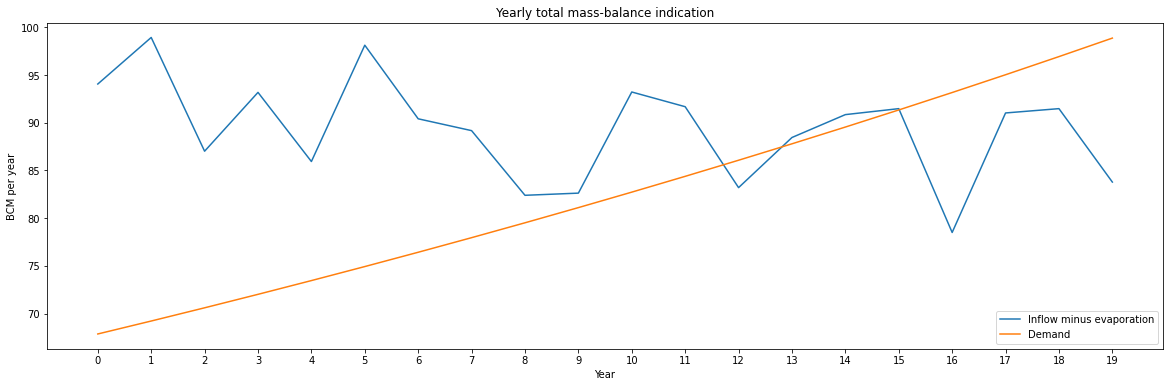

In [25]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(total_inflows-20, label="Inflow minus evaporation")
ax.plot(total_yearly_demand, label="Demand")
ax.legend()
plt.title("Yearly total mass-balance indication")
plt.ylabel("BCM per year")
plt.xlabel("Year")
plt.xticks(range(20))
plt.show()

Overall, the picture looks reasonable to me. Perhaps volatility of the input is larger than this generated baseline but I will try to cope with that after doing the baseline optimization.